In [1]:
%matplotlib inline
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

torch.manual_seed(1)

In [2]:
# Softmax也在 torch.nn.functional
data = autograd.Variable(torch.randn(5))
print(data)
print(F.softmax(data, dim=0))
print(F.softmax(data, dim=0).sum()) #总和为一因为他是概率分布!
print(F.log_softmax(data, dim=0)) # 他也是 log_softmax

tensor([ 0.6614,  0.2669,  0.0617,  0.6213, -0.4519])
tensor([0.2847, 0.1919, 0.1563, 0.2735, 0.0935])
tensor(1.)
tensor([-1.2563, -1.6507, -1.8559, -1.2963, -2.3695])


In [3]:
data = [("me gusta comer en la cafeteria".split(), "SPANISH"),
("Give it to me".split(), "ENGLISH"),
("No creo que sea una buena idea".split(), "SPANISH"),
("No it is not a good idea to get lost at sea".split(), "ENGLISH")]
#print(data)
test_data = [("Yo creo que si".split(), "SPANISH"),
("it is lost on me".split(), "ENGLISH")]
# word_to_ix 将在词汇中的单词映射为一个特征数,
# 这个特征数就是单词在词袋中的索引
word_to_ix = {}
for sent, _ in data + test_data:
    for word in sent:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
print(word_to_ix)
VOCAB_SIZE = len(word_to_ix)
NUM_LABELS = 2

{'it': 7, 'que': 11, 'a': 18, 'on': 25, 'lost': 21, 'Give': 6, 'not': 17, 'una': 13, 'creo': 10, 'get': 20, 'No': 9, 'gusta': 1, 'la': 4, 'idea': 15, 'sea': 12, 'good': 19, 'si': 24, 'Yo': 23, 'at': 22, 'is': 16, 'me': 0, 'to': 8, 'buena': 14, 'comer': 2, 'en': 3, 'cafeteria': 5}


In [4]:
print('data + test_data:\n',data + test_data)
print('------------------------------------------------------------------------------------')
for sent, kind in data + test_data:
    print(sent,kind)
print(VOCAB_SIZE)

data + test_data:
 [(['me', 'gusta', 'comer', 'en', 'la', 'cafeteria'], 'SPANISH'), (['Give', 'it', 'to', 'me'], 'ENGLISH'), (['No', 'creo', 'que', 'sea', 'una', 'buena', 'idea'], 'SPANISH'), (['No', 'it', 'is', 'not', 'a', 'good', 'idea', 'to', 'get', 'lost', 'at', 'sea'], 'ENGLISH'), (['Yo', 'creo', 'que', 'si'], 'SPANISH'), (['it', 'is', 'lost', 'on', 'me'], 'ENGLISH')]
------------------------------------------------------------------------------------
['me', 'gusta', 'comer', 'en', 'la', 'cafeteria'] SPANISH
['Give', 'it', 'to', 'me'] ENGLISH
['No', 'creo', 'que', 'sea', 'una', 'buena', 'idea'] SPANISH
['No', 'it', 'is', 'not', 'a', 'good', 'idea', 'to', 'get', 'lost', 'at', 'sea'] ENGLISH
['Yo', 'creo', 'que', 'si'] SPANISH
['it', 'is', 'lost', 'on', 'me'] ENGLISH
26


In [5]:
class BoWClassifier(nn.Module): # 从 nn.Module继承!

    def __init__(self, num_labels, vocab_size):
        # 在 nn.Module中调用初始化函数. 不要被这个困惑,
        # 这个做法经常在 nn.Module见到
        super(BoWClassifier, self).__init__()

        # 定义你需要的变量. 在本例中, 我们需要affine mapping的系数 A 和 b.
        # Torch 定义了可提供 affine map的nn.Linear().
        # 确定你理解了为什么输入矩阵的维度是 vocab_size而输出的是num_labels!
        self.linear = nn.Linear(vocab_size, num_labels)

        # 注意! non-linearity log softmax 没有系数!
        # 所以我们在这并不需要担心

    def forward(self, bow_vec):
        # 将输入引入到线性神经元层中, 随后引入到log_softmax.
        # 在torch.nn.functional中有很多非线性和其他的函数
        return F.log_softmax(self.linear(bow_vec), dim=1)

def make_bow_vector(sentence, word_to_ix):
    vec = torch.zeros(len(word_to_ix))
    for word in sentence:
        vec[word_to_ix[word]] += 1
    return vec.view(1, -1)

def make_target(label, label_to_ix):
    return torch.LongTensor([label_to_ix[label]])

model = BoWClassifier(NUM_LABELS, VOCAB_SIZE)
# model = BoWClassifier(2, 26)
# model知道它的系数.第一个输出的是A, 第二个是b.
# 当你在模块__init__函数中指定一个神经元去分类变量, self.linear = nn.Linear(...)被执行
# 随后从Pytorch devs通过Python magic, 你的模块(在本例中, BoWClassifier) 将会存储 nn.Linear的系数
for param in model.parameters():
    print(param.size(),param)
print('------------------------------------------------------------------------------------')
# 要运行该模型, 请传入一个BoW vector, 但要将其封装在一个autograd.Variable中.
sample = data[0]
bow_vector = make_bow_vector(sample[0], word_to_ix)
log_probs = model(autograd.Variable(bow_vector))
print(log_probs)

torch.Size([2, 26]) Parameter containing:
tensor([[ 0.0716, -0.0764, -0.0143, -0.0177,  0.0284, -0.0008,  0.1714,  0.0610,
         -0.0730, -0.1184, -0.0329, -0.0846, -0.0628,  0.0094,  0.1169,  0.1066,
         -0.1917,  0.1216,  0.0548,  0.1860,  0.1294, -0.1787, -0.1865, -0.0946,
          0.1722, -0.0327],
        [ 0.0839, -0.0911,  0.1924, -0.0830,  0.1471,  0.0023, -0.1033,  0.1008,
         -0.1041,  0.0577, -0.0566, -0.0215, -0.1885, -0.0935,  0.1064, -0.0477,
          0.1953,  0.1572, -0.0092, -0.1309,  0.1194,  0.0609, -0.1268,  0.1274,
          0.1191,  0.1739]], requires_grad=True)
torch.Size([2]) Parameter containing:
tensor([-0.1099, -0.0323], requires_grad=True)
------------------------------------------------------------------------------------
tensor([[-0.8766, -0.5382]], grad_fn=<LogSoftmaxBackward>)


In [6]:
label_to_ix = {"SPANISH": 0, "ENGLISH": 1}

In [7]:
# 在我们训练前运行训练集, 去看看前后的变化
for instance, label in test_data:
    bow_vec = autograd.Variable(make_bow_vector(instance, word_to_ix))
    log_probs = model(bow_vec)
    print(log_probs)
# 在矩阵中输出"creo"列
print(next(model.parameters()), word_to_ix["creo"])
print(next(model.parameters())[:, word_to_ix["creo"]])

tensor([[-0.8462, -0.5604]], grad_fn=<LogSoftmaxBackward>)
tensor([[-1.2863, -0.3234]], grad_fn=<LogSoftmaxBackward>)
Parameter containing:
tensor([[ 0.0716, -0.0764, -0.0143, -0.0177,  0.0284, -0.0008,  0.1714,  0.0610,
         -0.0730, -0.1184, -0.0329, -0.0846, -0.0628,  0.0094,  0.1169,  0.1066,
         -0.1917,  0.1216,  0.0548,  0.1860,  0.1294, -0.1787, -0.1865, -0.0946,
          0.1722, -0.0327],
        [ 0.0839, -0.0911,  0.1924, -0.0830,  0.1471,  0.0023, -0.1033,  0.1008,
         -0.1041,  0.0577, -0.0566, -0.0215, -0.1885, -0.0935,  0.1064, -0.0477,
          0.1953,  0.1572, -0.0092, -0.1309,  0.1194,  0.0609, -0.1268,  0.1274,
          0.1191,  0.1739]], requires_grad=True) 10
tensor([-0.0329, -0.0566], grad_fn=<SelectBackward>)


0.762496292591095
0.4778616428375244
0.33652955293655396
0.2556207776069641
0.2045934945344925
0.16989722847938538
0.14493465423583984
0.1261860579252243
0.1116245687007904
0.10000835359096527
0.09053744375705719
0.08267492055892944
0.07604753971099854
0.07038846611976624
0.06550195813179016
0.061241328716278076
0.05749458074569702
0.05417466163635254
0.051213234663009644
0.04855555295944214
0.04615744948387146
0.04398295283317566
0.042002320289611816
0.040190935134887695
0.03852808475494385
0.03699636459350586
0.035580843687057495
0.03426888585090637
0.033049553632736206
0.03191351890563965
0.030852466821670532
0.029859274625778198
0.028927624225616455
0.028052061796188354
0.027227580547332764
0.026449978351593018
0.02571532130241394
0.025020241737365723
0.024361401796340942
0.023736268281936646
0.023142307996749878
0.02257716655731201
0.02203887701034546
0.021525532007217407
0.021035432815551758
0.020567119121551514
0.020119071006774902
0.01969003677368164
0.019278883934020996
0.0188

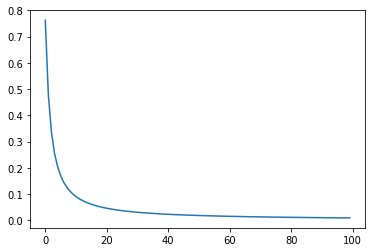

In [8]:
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# 通常你想要多次浏览训练集.100比起实际数据集是很多的, 但实际数据集会多于2个实例.
# 通常, 在5到30之间是合理的.
LOSS = []
for epoch in range(100):
    Loss = 0
    for instance, label in data:
        # 步骤 1\. 牢记 Pytorch 会积累梯度.
        # 我们需要在每一例前清理掉
        model.zero_grad()

        # 步骤 2\. 制作我们的 BOW 向量 并且我们必须将目标封装在变量中并且为整数 .
        # 例如, 如果目标是"西班牙语", 则封装为整数0.对于损失函数而言, 概率分布的
        # 第0列对应的是"西班牙语"的损失函数.
        #
        bow_vec = autograd.Variable(make_bow_vector(instance, word_to_ix))
        target = autograd.Variable(make_target(label, label_to_ix))

        # 步骤 3\. Run our forward pass.
        log_probs = model(bow_vec)

        # 步骤 4\. 计算损失, 梯度, 通过调用optimizer.step()来更新系数
        #
        loss = loss_function(log_probs, target)
        Loss += loss
        loss.backward()
        optimizer.step()
    Loss = Loss/4
    LOSS.append(Loss)
    print(Loss.item())
plt.plot(LOSS)
plt.show()